In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, classification_report, roc_curve, auc, confusion_matrix)
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
plt.rcParams['figure.figsize'] = (8,6)


In [2]:
DATA_PATH = 'heart_disease_dataset.csv'  # change if needed
if not os.path.exists(DATA_PATH):
    raise FileNotFoundError(f"Dataset file not found at '{DATA_PATH}'. Place your CSV there.")
df = pd.read_csv(DATA_PATH)
print("Loaded dataset shape:", df.shape)
display(df.head())

expected_rows = 400
if df.shape[0] != expected_rows:
    print(f"Warning: dataset has {df.shape[0]} rows (expected {expected_rows}). Proceeding anyway.")
else:
    print("Record count matches expected 400 rows.")


Loaded dataset shape: (400, 14)


,age,sex,chest_pain_type,resting_blood_pressure,cholesterol,fasting_blood_sugar,resting_ecg,max_heart_rate,exercise_induced_angina,st_depression,st_slope,num_major_vessels,thalassemia,heart_disease
0,58,1,1,134,246,0,0,155,0,0.4,1,1,2,1
1,52,0,2,112,245,0,0,143,1,0.1,0,0,3,1
2,59,0,2,126,196,0,0,162,1,1.1,1,0,1,1
3,67,1,1,165,201,0,0,180,0,0.4,2,0,2,0
4,51,1,0,146,174,1,1,133,1,0.9,1,1,2,1


Record count matches expected 400 rows.


In [3]:
expected_target = 'heart_disease'
if 'target' in df.columns and expected_target not in df.columns:
    df = df.rename(columns={'target': expected_target})

if expected_target not in df.columns:
    raise KeyError(f"Target column '{expected_target}' not found in dataset. Found columns: {list(df.columns)}")

# Determine feature columns (all except target)
feature_cols = [c for c in df.columns if c != expected_target]
print("Feature columns:", feature_cols)
print("Number of features:", len(feature_cols))


Feature columns: ['age', 'sex', 'chest_pain_type', 'resting_blood_pressure', 'cholesterol', 'fasting_blood_sugar', 'resting_ecg', 'max_heart_rate', 'exercise_induced_angina', 'st_depression', 'st_slope', 'num_major_vessels', 'thalassemia']
Number of features: 13


In [4]:
print("\nData types:\n", df.dtypes)
print("\nMissing values (per column):\n", df.isnull().sum())

# Show target distribution
print("\nTarget value counts:\n", df[expected_target].value_counts())



Data types:
 age                          int64
sex                          int64
chest_pain_type              int64
resting_blood_pressure       int64
cholesterol                  int64
fasting_blood_sugar          int64
resting_ecg                  int64
max_heart_rate               int64
exercise_induced_angina      int64
st_depression              float64
st_slope                     int64
num_major_vessels            int64
thalassemia                  int64
heart_disease                int64
dtype: object

Missing values (per column):
 age                        0
sex                        0
chest_pain_type            0
resting_blood_pressure     0
cholesterol                0
fasting_blood_sugar        0
resting_ecg                0
max_heart_rate             0
exercise_induced_angina    0
st_depression              0
st_slope                   0
num_major_vessels          0
thalassemia                0
heart_disease              0
dtype: int64

Target value counts:
 heart_dis

In [5]:
X = df[feature_cols].copy()
y = df[expected_target].astype(int).copy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)
print("Train shape:", X_train.shape, "Test shape:", X_test.shape)
print("Train class proportions:\n", y_train.value_counts(normalize=True))
print("Test class proportions:\n", y_test.value_counts(normalize=True))


Train shape: (320, 13) Test shape: (80, 13)
Train class proportions:
 heart_disease
1    0.55625
0    0.44375
Name: proportion, dtype: float64
Test class proportions:
 heart_disease
1    0.55
0    0.45
Name: proportion, dtype: float64


In [ ]:
    # 5) Feature scaling for models that need it (Logistic Regression, SVM).

    numeric_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
    print("Numeric columns to scale:", numeric_cols)

    scaler = StandardScaler()
    X_train_scaled = X_train.copy()
    X_test_scaled = X_test.copy()
    X_train_scaled[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
    X_test_scaled[numeric_cols] = scaler.transform(X_test[numeric_cols])


Numeric columns to scale: ['age', 'sex', 'chest_pain_type', 'resting_blood_pressure', 'cholesterol', 'fasting_blood_sugar', 'resting_ecg', 'max_heart_rate', 'exercise_induced_angina', 'st_depression', 'st_slope', 'num_major_vessels', 'thalassemia']


In [7]:
# 6) Build models dictionary
models = {
    'LogisticRegression': LogisticRegression(max_iter=1000, random_state=RANDOM_STATE),
    'DecisionTree': DecisionTreeClassifier(random_state=RANDOM_STATE),
    'RandomForest': RandomForestClassifier(n_estimators=200, random_state=RANDOM_STATE),
    'SVM': SVC(probability=True, random_state=RANDOM_STATE)
}

trained_models = {}
metrics_summary = {}
probs_for_roc = {}

In [8]:
# 7) Train, predict and evaluate each model
# %%
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
for name, model in models.items():
    print(f"\nTraining {name} ...")
    if name in ('LogisticRegression', 'SVM'):
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        y_prob = model.predict_proba(X_test_scaled)[:,1]
        cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=skf, scoring='roc_auc')
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_prob = model.predict_proba(X_test)[:,1]
        cv_scores = cross_val_score(model, X_train, y_train, cv=skf, scoring='roc_auc')
    
    metrics = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred, zero_division=0),
        'recall': recall_score(y_test, y_pred, zero_division=0),
        'f1': f1_score(y_test, y_pred, zero_division=0),
        'roc_auc': roc_auc_score(y_test, y_prob)
    }
    trained_models[name] = model
    metrics_summary[name] = metrics
    probs_for_roc[name] = y_prob
    print("Metrics:", {k: round(v,4) for k,v in metrics.items()})
    print("5-fold CV ROC-AUC (train):", f"{cv_scores.mean():.4f} ± {cv_scores.std():.4f}")
    print("Classification report:\n", classification_report(y_test, y_pred, zero_division=0))



Training LogisticRegression ...
Metrics: {'accuracy': 0.675, 'precision': 0.6957, 'recall': 0.7273, 'f1': 0.7111, 'roc_auc': 0.7342}
5-fold CV ROC-AUC (train): 0.7445 ± 0.0352
Classification report:
               precision    recall  f1-score   support

           0       0.65      0.61      0.63        36
           1       0.70      0.73      0.71        44

    accuracy                           0.68        80
   macro avg       0.67      0.67      0.67        80
weighted avg       0.67      0.68      0.67        80


Training DecisionTree ...


Metrics: {'accuracy': 0.575, 'precision': 0.6, 'recall': 0.6818, 'f1': 0.6383, 'roc_auc': 0.5631}
5-fold CV ROC-AUC (train): 0.5591 ± 0.0724
Classification report:
               precision    recall  f1-score   support

           0       0.53      0.44      0.48        36
           1       0.60      0.68      0.64        44

    accuracy                           0.57        80
   macro avg       0.57      0.56      0.56        80
weighted avg       0.57      0.57      0.57        80


Training RandomForest ...
Metrics: {'accuracy': 0.6875, 'precision': 0.6939, 'recall': 0.7727, 'f1': 0.7312, 'roc_auc': 0.7816}
5-fold CV ROC-AUC (train): 0.7165 ± 0.0509
Classification report:
               precision    recall  f1-score   support

           0       0.68      0.58      0.63        36
           1       0.69      0.77      0.73        44

    accuracy                           0.69        80
   macro avg       0.69      0.68      0.68        80
weighted avg       0.69      0.69      0

In [9]:
#8) Tabulate and display metrics summary

metrics_df = pd.DataFrame(metrics_summary).T
metrics_df['cv_mean_roc_auc'] = [cross_val_score(trained_models[n], 
                                                 X_train_scaled if n in ('LogisticRegression','SVM') else X_train,
                                                 y_train, cv=skf, scoring='roc_auc').mean() for n in metrics_df.index]
metrics_df['cv_std_roc_auc'] = [cross_val_score(trained_models[n], 
                                                X_train_scaled if n in ('LogisticRegression','SVM') else X_train,
                                                y_train, cv=skf, scoring='roc_auc').std() for n in metrics_df.index]
display(metrics_df.sort_values(by='roc_auc', ascending=False))


,accuracy,precision,recall,f1,roc_auc,cv_mean_roc_auc,cv_std_roc_auc
RandomForest,0.6875,0.693878,0.772727,0.731183,0.781566,0.716475,0.050902
SVM,0.6500,0.673913,0.704545,0.688889,0.735480,0.690211,0.071320
LogisticRegression,0.6750,0.695652,0.727273,0.711111,0.734217,0.744488,0.035184
DecisionTree,0.5750,0.600000,0.681818,0.638298,0.563131,0.559111,0.072428


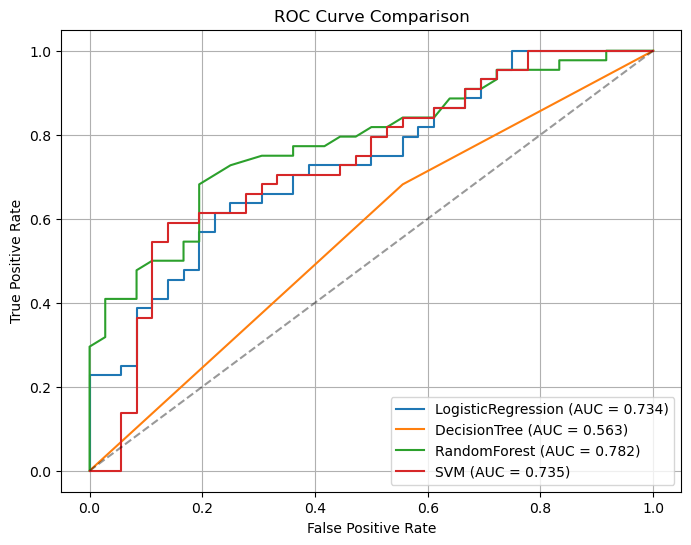

Saved: roc_comparison.png


<Figure size 800x600 with 0 Axes>

In [10]:
# 9) Plot ROC curves for all models
# %%
plt.figure()
for name, y_prob in probs_for_roc.items():
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc(fpr,tpr):.3f})")
plt.plot([0,1],[0,1],'k--', alpha=0.4)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()
plt.savefig('roc_comparison.png', bbox_inches='tight')
print("Saved: roc_comparison.png")


Dataset shape: (400, 14)
   age  sex  chest_pain_type  resting_blood_pressure  cholesterol  \
0   58    1                1                     134          246   
1   52    0                2                     112          245   
2   59    0                2                     126          196   
3   67    1                1                     165          201   
4   51    1                0                     146          174   

   fasting_blood_sugar  resting_ecg  max_heart_rate  exercise_induced_angina  \
0                    0            0             155                        0   
1                    0            0             143                        1   
2                    0            0             162                        1   
3                    0            0             180                        0   
4                    1            1             133                        1   

   st_depression  st_slope  num_major_vessels  thalassemia  heart_disease  
0  

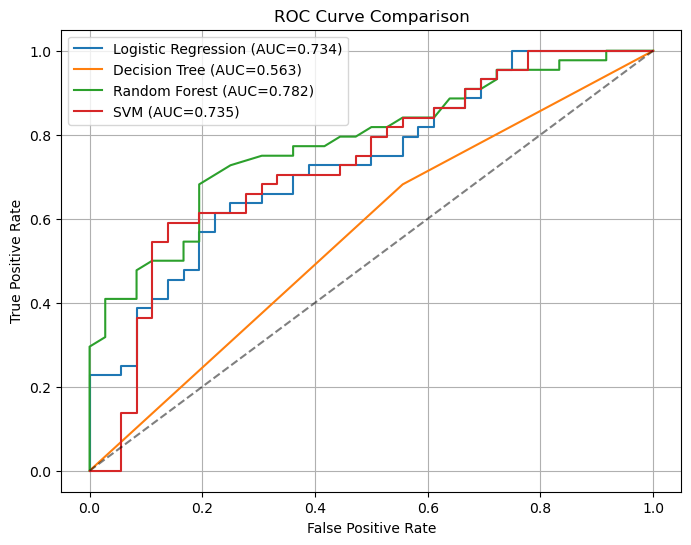

In [ ]:
# Heart Disease Prediction - Simplified Version
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# 1. Load Dataset
df = pd.read_csv("heart_disease_dataset.csv")
print("Dataset shape:", df.shape)
print(df.head())

# 2. Check basic info
print("\nMissing values:\n", df.isnull().sum())
print("\nTarget counts:\n", df['heart_disease'].value_counts())

# 3. Split data into features (X) and target (y)
X = df.drop('heart_disease', axis=1)
y = df['heart_disease']

# 4. Train-test split (80%-20%)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
print("\nTrain size:", X_train.shape, "| Test size:", X_test.shape)

# 5. Feature scaling (for Logistic Regression and SVM)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 6. Define models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42),
    "SVM": SVC(probability=True, random_state=42)
}

# 7. Train and Evaluate Models
results = []
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for name, model in models.items():
    print(f"\n🔹 Training {name}...")
    # Use scaled data only for LogisticRegression and SVM
    X_tr = X_train_scaled if name in ["Logistic Regression", "SVM"] else X_train
    X_te = X_test_scaled if name in ["Logistic Regression", "SVM"] else X_test
    
    model.fit(X_tr, y_train)
    y_pred = model.predict(X_te)
    y_prob = model.predict_proba(X_te)[:, 1]
    
    # Calculate metrics
    metrics = {
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1 Score": f1_score(y_test, y_pred),
        "ROC AUC": roc_auc_score(y_test, y_prob),
        "CV AUC Mean": cross_val_score(model, X_tr, y_train, cv=cv, scoring='roc_auc').mean()
    }
    results.append(metrics)
    print(classification_report(y_test, y_pred))

# 8. Display summary table
results_df = pd.DataFrame(results)
print("\nModel Comparison:\n", results_df.sort_values(by="ROC AUC", ascending=False))

# 9. Plot ROC Curves
plt.figure(figsize=(8, 6))
for name, model in models.items():
    X_te = X_test_scaled if name in ["Logistic Regression", "SVM"] else X_test
    y_prob = model.predict_proba(X_te)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.plot(fpr, tpr, label=f"{name} (AUC={auc(fpr, tpr):.3f})")

plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
plt.title("ROC Curve Comparison")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.show()
s